In [49]:
import pymc as pm
import numpy as np
import arviz as az
from pymc.math import logit, exp
import matplotlib.pyplot as plt
import xarray as xr

%load_ext lab_black

The lab_black extension is already loaded. To reload it, use:
  %reload_ext lab_black


# Cumulative Example*

Adapted from [Unit 9: cumulative2.odc](https://raw.githubusercontent.com/areding/6420-pymc/main/original_examples/Codes4Unit9/cumulative2.odc).

Use of ```cumulative``` as a check for outliers.

How consistent are the data with the model? Check ```cumulative(y[i], y[i])```.

The first y[i] specifies the distribution of y[i]'s, the second is the argument/observation. The output is empirical cdf of y[i]s evaluated at y[i].

Values close to 0 or 1 are potential outliers.

## Notes

The idea here seems to be based on the [probability integral transform](https://en.wikipedia.org/wiki/Probability_integral_transform). The problem I'm having is I don't know exactly how the BUGS ```cumulative``` function works - it doesn't seem to be in the docs. Is it using KDE to approximate the cdf or what?

For now, I recommend checking out plots like the examples below to look for outliers. I'll try to come back to this example in the future.

In [50]:
# fmt: off
y = np.array(
    [0.0, 1.0, 2.0, -1.0, 0.4, -0.5, 0.7, -1.2, 0.1, -0.4, 
     0.2, -0.5, -1.4, 1.8, 0.2, 0.3, -0.6, 1.1, 5.1, -6.3]
)
# fmt: on

In [59]:
with pm.Model() as m:
    theta = pm.Flat("theta")
    log_sigma = pm.Flat("log_sigma")
    tau = pm.Deterministic("tau", 1 / exp(2 * log_sigma))

    pm.Normal("y", mu=theta, tau=tau, observed=y)

    trace = pm.sample(2000)

    pm.sample_posterior_predictive(trace, extend_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta, log_sigma]


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 1 seconds.
Sampling: [y]


In [60]:
az.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
theta,0.050,0.487,-0.843,1.009,0.006,0.006,5754.0,4864.0,1.0
log_sigma,0.753,0.167,0.430,1.059,0.002,0.002,6640.0,5523.0,1.0
tau,0.234,0.076,0.102,0.379,0.001,0.001,6640.0,5523.0,1.0


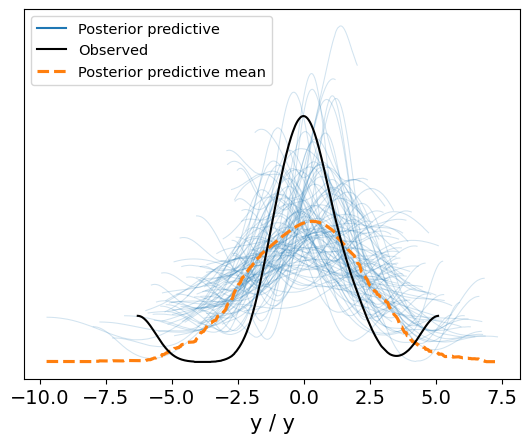

In [61]:
az.plot_ppc(trace, num_pp_samples=100)
plt.show()

Doesn't look like our posterior does a good job of fitting the observed data because of the outliers.

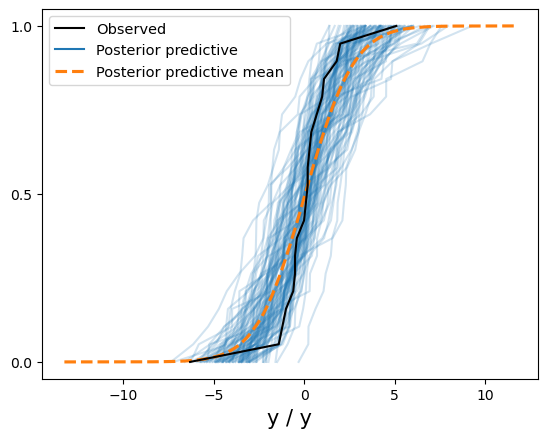

In [62]:
az.plot_ppc(trace, kind="cumulative", num_pp_samples=100)
plt.show()

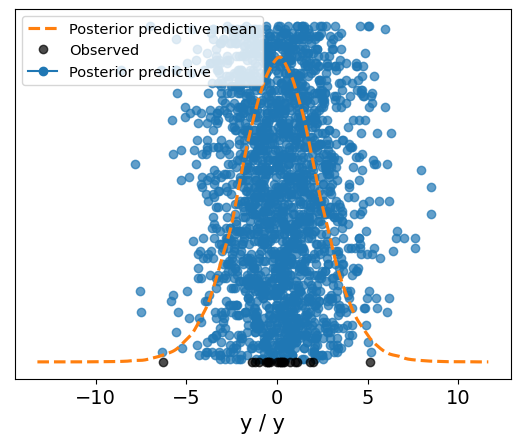

In [63]:
az.plot_ppc(trace, kind="scatter", num_pp_samples=100)
plt.show()

The below code is not working for me since PyMC 5. I'm not sure what happened. It should look like the example below, from their [documentation](https://python.arviz.org/en/v0.15.1/api/generated/arviz.plot_lm.html).

In [75]:
pred = pm.sample_posterior_predictive(trace, model=m, predictions=True, extend_inferencedata=True, idata_kwargs={"log_likelihood": True})
x = xr.DataArray(np.linspace(0, 1, 20))
az.plot_lm(idata=pred, y="y", x=x)

Sampling: [y]


TypeError: predictions_to_inference_data() got an unexpected keyword argument 'log_likelihood'

array([[<AxesSubplot: ylabel='y'>]], dtype=object)

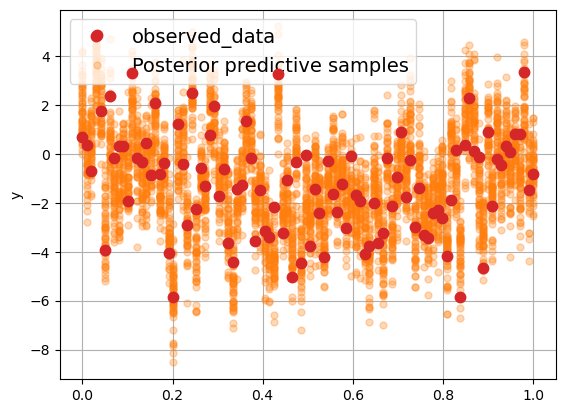

In [20]:
# docs example
x = xr.DataArray(np.linspace(0, 1, 100))
az.plot_lm(idata=idata, y="y", x=x)

In [ ]:
%load_ext watermark
%watermark -n -u -v -iv -p pytensor